In [1]:
import numpy as np

In [2]:
from scipy.sparse import csr_matrix as csr
from scipy.sparse import diags
from scipy.sparse import linalg

In [3]:
import matplotlib.pyplot as plt

# Grid Geometry

In [4]:
grid_num = 200

In [5]:
grid_xedge = 1000./grid_num
grid_yedge = 200
grid_zedge = 10

In [6]:
grid_xcenter = np.arange(grid_xedge/2,1000+grid_xedge/2,grid_xedge)

In [7]:
grid_xarea = grid_yedge*grid_zedge

# Rock Properties

In [8]:
rock_poro = 0.2
rock_xperm = 100
rock_comp = 0

# Black Oil System

In [9]:
oil_visc = 1
oil_comp = 0
oil_fvf = 1

In [10]:
wat_visc = 1
wat_comp = 0
wat_fvf = 1

In [11]:
def krw(Sw):
  return 0.3*((Sw-0.2)/(1-0.2-0.4))**2

In [12]:
def kro(Sw):
  return 0.8*((1.0-Sw-0.4)/(1-0.2-0.4))**2

# Well Input

In [13]:
w1_block = (0,)
w1_radius = 0.25
w1_wrate = 1000
w1_skin = 0

In [14]:
w2_block = (grid_num-1,)
w2_radius = 0.25
w2_rate = -1000
w2_skin = 0

# Time Settings

In [15]:
deltat = 0.1
tsteps = 1500

# Reservoir Initialization

In [16]:
init_press = 1000 # not used in the calculations
init_swater = 0.2 # not used in the calculations

In [17]:
Pn = np.zeros((grid_num,))+init_press

In [18]:
Swn = np.zeros((grid_num,))+init_swater

# Transmissibility Calculations

In [19]:
xrock = (rock_xperm*grid_xarea)/grid_xedge*6.33e-3

In [20]:
def upwinding(Mo,Mw,Pn):
    
    Mo_upwinded = Mo[:-1]
    Mw_upwinded = Mw[:-1]
    
    Mo_upwinded[Pn[1:]>Pn[:-1]] = Mo[1:][Pn[1:]>Pn[:-1]]
    Mw_upwinded[Pn[1:]>Pn[:-1]] = Mw[1:][Pn[1:]>Pn[:-1]]

    return Mo_upwinded,Mw_upwinded

# Storage and Total Compressibility Calculations

In [21]:
accum = grid_xarea*grid_xedge*rock_poro/deltat

In [22]:
def get_ct(cr,co,cw,Sw):
  return cr+Sw*cw+(1-Sw)*co

# Well B.C. Calculations

In [23]:
def equivalent_radius(perm1,perm2,edge1,edge2):
    """Returns equivalent radius of grids that contains well."""
    sqrt21 = np.power(perm2/perm1,1/2)*np.power(edge1,2)
    sqrt12 = np.power(perm1/perm2,1/2)*np.power(edge2,2)

    quar21 = np.power(perm2/perm1,1/4)
    quar12 = np.power(perm1/perm2,1/4)

    return 0.28*np.sqrt(sqrt21+sqrt12)/(quar21+quar12)

In [24]:
req = equivalent_radius(rock_xperm,rock_xperm,grid_xedge,grid_yedge)

In [25]:
w1_PI = (2*np.pi*grid_zedge*rock_xperm)/(np.log(req/w1_radius)+w1_skin)*6.33e-3
w2_PI = (2*np.pi*grid_zedge*rock_xperm)/(np.log(req/w2_radius)+w2_skin)*6.33e-3

# Matrix Construction

In [26]:
def matrix(grid_num,wtrans,otrans,Mw,Mo):
    
    tindex = np.arange(grid_num)

    Tw = csr((grid_num,grid_num))

    Tw += csr((wtrans,(tindex[:-1],tindex[:-1])),shape=(grid_num,grid_num))
    Tw -= csr((wtrans,(tindex[:-1],tindex[1:] )),shape=(grid_num,grid_num))
    
    Tw += csr((wtrans,(tindex[1:], tindex[1:] )),shape=(grid_num,grid_num))
    Tw -= csr((wtrans,(tindex[1:], tindex[:-1])),shape=(grid_num,grid_num))

    To = csr((grid_num,grid_num))
    
    To += csr((otrans,(tindex[:-1],tindex[:-1])),shape=(grid_num,grid_num))
    To -= csr((otrans,(tindex[:-1],tindex[1:] )),shape=(grid_num,grid_num))
    
    To += csr((otrans,(tindex[1:], tindex[1:] )),shape=(grid_num,grid_num))
    To -= csr((otrans,(tindex[1:], tindex[:-1])),shape=(grid_num,grid_num))

    qindex = np.array([*w1_block,*w2_block])

    qwmatx = np.array([w1_wrate,w2_rate*Mw[w2_block]/(Mw[w2_block]+Mo[w2_block])])
    qomatx = np.array([0       ,w2_rate*Mo[w2_block]/(Mw[w2_block]+Mo[w2_block])])

    Qw = csr((qwmatx,(qindex,(0,0))),shape=(grid_num,1))
    Qo = csr((qomatx,(qindex,(0,0))),shape=(grid_num,1))

    return Tw,To,Qw,Qo

# Time Loop

In [27]:
A = csr((np.ones((grid_num,))*accum,(np.arange(grid_num),np.arange(grid_num))),shape=(grid_num,grid_num))

In [28]:
Sw_data = np.zeros((grid_num,tsteps+1))
Sw_data[:,0] = Swn

In [29]:
for k in range(tsteps):
    
    Mo = kro(Swn)/(oil_visc*oil_fvf)
    Mw = krw(Swn)/(wat_visc*wat_fvf)
    
    Mou,Mwu = upwinding(Mo,Mw,Pn)

    otrans = Mou*xrock
    wtrans = Mwu*xrock

    Tw,To,Qw,Qo = matrix(grid_num,wtrans,otrans,Mw,Mo)

    T = Tw+To+diags(np.ones((grid_num,))*1e-10)
    Q = Qw+Qo

    Pn = linalg.spsolve(T,Q)
    
    Swn = Swn+linalg.spsolve(A,-Tw.dot(csr(Pn.reshape((-1,1))))+Qw)

    Sw_data[:,k+1] = Swn

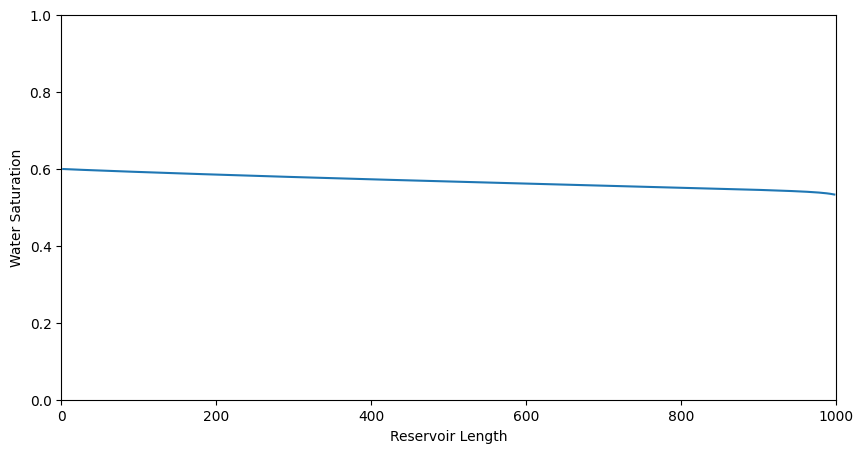

In [33]:
fig = plt.figure(figsize=(10,5))

ax = plt.subplot(1,1,1)

ax.set_xlabel('Reservoir Length')
ax.set_ylabel('Water Saturation')

ax.set_xlim((0,1000))
ax.set_ylim((0,1.))

line, = ax.plot([],[])

line.set_data(grid_xcenter, Swn)

In [31]:
def drawframe(n):
    
    line.set_data(grid_xcenter, Sw_data[:,n])

    return (line,)

In [32]:
from matplotlib import animation
from IPython.display import HTML

anim = animation.FuncAnimation(fig, drawframe, frames=tsteps, interval=20, blit=True)
anim.save(filename="rs32_twophase_1D_impes_buckley.gif", writer="pillow")
# HTML(anim.to_html5_video())